In [1]:
%reset_selective -f [model]
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from math import sqrt, ceil
import csv

NUMERICALTHRESHOLD = 1e-10

class SLN:
    
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.input_weights = np.random.rand(input_size,hidden_size)
        self.output_weights = np.random.rand(hidden_size,output_size)        
        self.biases = np.random.rand(hidden_size)
    
    def hidden_layer(self,X):
        G= np.dot(X, self.input_weights)
        G = G + self.biases
        return(self.sigmoid(G))
    
    def predict(self,X):
        H=self.hidden_layer(X)
        return(np.dot(H, self.output_weights))        
               
    def train(self, X, y):
        if( (X.shape[1] == self.input_size) and  (y.shape[1] == self.output_size) ):
            H=self.hidden_layer(X)
            self.clear(H)
            self.H=H
            Hplus = np.linalg.pinv(H)
            self.clear(Hplus)
            self.Hplus=Hplus
            self.output_weights = np.dot(Hplus,y)
            self.clear(self.output_weights)
            #self.data=X
            self.labels=y
        else:
            print("Error: cannot match shapes:", X.shape, " with ", self.input_weights.shape, " and ", self.output_weights.shape, " with ", y.shape)  

    def loss(self,X,y):         
        diff = self.predict(X) - y
        n=len(diff)
        return(1/n*sum([np.linalg.norm(x)**2 for x in diff]))
            
    def sigmoid(self,z):
        return 1/(1 + np.exp(-z))

    def clear(self, A):
        n,m=A.shape
        for i in range(n):
            for j in range(m):
                if(abs(A[i,j]) < NUMERICALTHRESHOLD):
                    A[i,j]=0.0                 
    
    def recPinv(self,A,a,Ap):        
        d=np.dot(a,Ap)
        c=a-np.dot(d,A)
        flag=False
        self.clear(c)
        if(not np.all(c==0)):
            b=(1/np.dot(c,c.transpose()))*c.transpose()
        else:
            flag=True
            k = (1 + np.dot(d,d.transpose()))
            b = (1/k)*np.dot(Ap,d.transpose())
        B = Ap-np.dot(b,d)
        self.clear(B)
        return(np.hstack((B,b)),flag)
                    
    def sequential_learning(self, x, y):                
        a=self.hidden_layer(x)
        A=self.H
        #p=self.Hplus
        #new,flag = self.recPinv(A,a,Ap)    
        #elf.clear(Hnew) 
        Anew = np.vstack((A,a))        
        Hnew2 = np.linalg.pinv(Anew)
        #U1=np.dot(Hnew, Anew)
        #self.clear(U1)
        #U2=np.dot(Hnew2, Anew)
        #print(U1);print(U2)
        #print("---")
        ynew = np.vstack((self.labels,y))        
        #weights = np.dot(Hnew,ynew)
        weights = np.dot(Hnew2,ynew)
        #self.clear(weights)
        self.output_weights = weights
        return(False)

    
####################### ELM ende########################

 

In [2]:

from tqdm.notebook import trange, tqdm
def f(x):
    return(np.sin(x))

def testit(model, f,   N=100, test_size=0.9, learnrate=0.5, shuffle=True, printing=False):
    plotx = np.arange(N)*(1/N)
    ploty = f( plotx)
    plotx.resize((N,1))
    ploty.resize((N,1))
    x=plotx.copy()
    y=ploty.copy()
    x.resize((N,1))
    y.resize((N,1))
    xtr, xtest, ytr, ytest = train_test_split(x, y, test_size=test_size,shuffle=shuffle)
    # 20% für Testdaten zum validieren. Anlernen 20% der Trainingsdaten     # sequentielles Lernen bis auf 80%

    initN=int(N*learnrate*(1-test_size))
    testN=int(N*(1-learnrate)*(1-test_size))

    xtr_init = xtr[:initN]
    ytr_init = ytr[:initN]
    
    model.train(xtr_init,ytr_init)        
    
    if(printing):
        print("Prediction")
        prediction = model.predict(plotx)
        figure,axis=plt.subplots(1,1)
        figure.set_figwidth(10)
        figure.set_figheight(5)
        A = model.loss(xtest,ytest)
        plt.title("MSE der Testdaten vor dem Lernen:"+str(A))
        axis.scatter(plotx, ploty,s=.8, color="blue")
        axis.scatter(plotx, prediction,s=.8, color="red")       
        plt.show()
    
    
    MSELoss=[]            
    #for i in trange(initN+testN, desc="learning"):            
    for i in range(testN):            
            xx=np.array([xtr[i]])
            yy=np.array([ytr[i]])
            model.sequential_learning(xx,yy)
            MSELoss.append(model.loss(xtest,ytest))  
    
    if(printing):
        print("Prediction")
        prediction = model.predict(plotx)
        figure,axis=plt.subplots(1,1)
        figure.set_figwidth(10)
        figure.set_figheight(5)    
        axis.plot(plotx, ploty,color="blue")
        axis.plot(plotx, prediction,color="red")
        B = model.loss(xtest,ytest)
        plt.title("MSE der Testdaten vor dem Lernen:"+str(B))        
        plt.show()
        print("Loss-Function")
        xaxis=np.linspace(0,len(MSELoss)-1,len(MSELoss))    
        plt.plot(xaxis,np.array(MSELoss))
        plt.show()        
    print("MSE nach dem Lernen:", B)
    #return(m,plotx,ploty)

Prediction


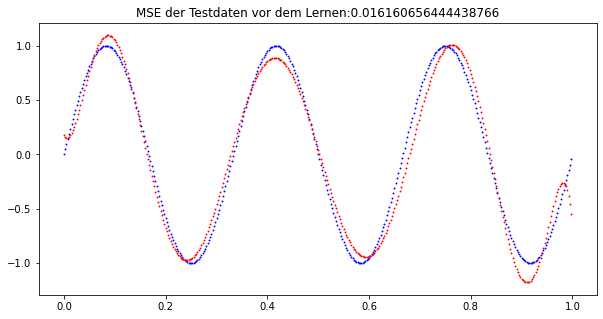

Prediction


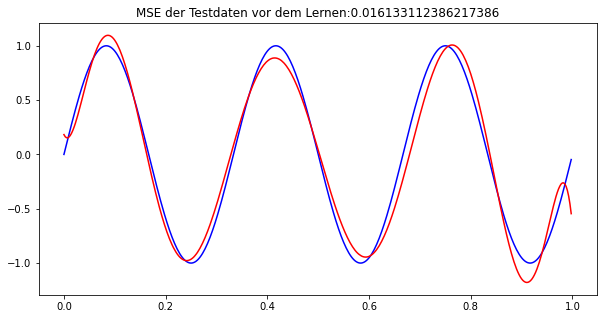

Loss-Function


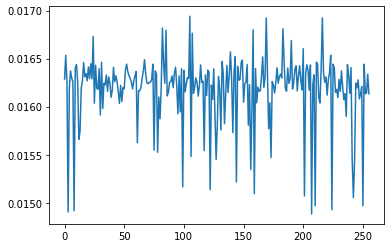

MSE nach dem Lernen: 0.016133112386217386


In [3]:
testit(SLN(1,100,1),lambda x: np.sin(6*np.pi*x), N=400, test_size=0.2, learnrate=0.2, printing=True)

In [80]:
model=SLN(1,10,1)

In [23]:
model.train(np.array([[0.0],[0.2],[0.4],[1.0]]),np.array([[0],[0.04],[0.16],[1.0]]))

In [24]:
model.recPinv(np.array([[1,2]]),np.array([[3,4]]),np.array([[0.2],[0.4]]))

(array([[-2. ,  1. ],
        [ 1.5, -0.5]]),
 False)